In this file, we will scrape wikipedia to get information on the historical congressional representatives of each US state. The final data frame will have all representatives from each state since 1960, their partisan affiliation, the year they entered congress, the year they left congress, and the district they will represent.

In [48]:
# first, we import the relevent packages.

# for data manipulation
import pandas as pd
import datetime as dt

# to scrape the web
from bs4 import BeautifulSoup as soupy
import requests
import time
import random

# dealing with consistent ssl error
import ssl

# for maths
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for writing dictionaries and others as files
import json

#### Step 1

Acquire and modify a list of States

In [2]:
# set the url for the site with the states
states_url = 'https://state.1keydata.com'

In [3]:
# make a connection to the page
states_page = requests.get(states_url, verify=False)

C:\Python39\lib\site-packages\urllib3\connectionpool.py:1013: InsecureRequestWarning: Unverified HTTPS request is being made to host 'state.1keydata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [4]:
# verify the connection
states_page.status_code

200

In [5]:
# get the actual html content
states_readable = soupy(states_page.content, 'html')

In [6]:
# now we need to initialize a list to store the states
# we initialize a list with 50 none values
# this makes it much faster to insert the value into the list
list_of_states = [None] * 50

In [7]:
# now we find all the href tags 
subset_states_readable = states_readable.find('div', {'id' : 'colwrap'})
href_all = subset_states_readable.find_all('a', href=True)

In [8]:
# then we get the text for each of the a tag values
for index, state in enumerate(href_all):
    value = state.text
    value = value.replace(' ', '_')
    list_of_states[index] = value

#### Step 2

Use the generated list to create a list of urls.

In [9]:
# we use a list comprehension to create the urls
list_of_states = [['https://en.wikipedia.org/wiki/List_of_United_States_representatives_from_' + a, a] for a in list_of_states]

#### Step 3

Scrape the table from each wikipedia page and create a pandas data frame.

In [10]:
# temporary ssl fix
ssl._create_default_https_context = ssl._create_unverified_context

In [11]:
# initialize a list for our pandas dataframes
# this is more efficient than appending multiple data frames
list_of_data_frames = [None] * 50
# get each table as a pandas data frame
# store it in the list
for index, (url, state) in enumerate(list_of_states):
    sleep = 4
    try:
        table = pd.read_html(url)[0].iloc[:,[0,1,2,3]]
        table.rename({table.columns[0]: 'Representative'}, axis = 'columns', inplace = True)
        for i in range(1,4):
            if 'Democratic' in table.iloc[:,i].values:
                table.rename({table.columns[i]: 'Party'}, axis = 'columns', inplace = True)
            elif ('1st' or 'At-large') in table.iloc[:,i].values:
                table.rename({table.columns[i]: 'District'}, axis = 'columns', inplace = True)
            else:
                table.rename({table.columns[i]: 'Years'}, axis = 'columns', inplace = True)
        table['State'] = state
        table[['Start', 'End']] = table['Years'].str.split('–' or '-', expand = True)
        table = table.drop(columns = 'Years')
        table['Start'] = table['Start'].str.strip()
        table['End'] = table['End'].str.strip()
        table['Start'] = pd.to_datetime(table['Start'], errors='coerce')
        table['End'] = table['End'].replace(['Present', 'present'], 'November 28, 2021')
        table['End'] = pd.to_datetime(table['End'], errors='coerce')
        list_of_data_frames[index] = table
        time.sleep(random.uniform(0,sleep))
    except:
        time.sleep(random.uniform(0,sleep))
        pass

In [12]:
res = [i for i in range(len(list_of_data_frames)) if list_of_data_frames[i] is None]

In [13]:
# this is a list of indexes where we did not store a dataframe
# we will have to go back and scrape these values individually
# should not matter much for results
res

[1, 7, 9, 10, 15, 18, 27, 49]

In [14]:
# combine the data frame
skel = pd.concat(list_of_data_frames, axis = 0, ignore_index = True)

In [16]:
# get rid of missingness
skel = skel[skel['Start'].isnull() == False]
skel = skel[skel['End'].isnull() == False]

In [17]:
# get year from start
skel['Start_Year'] = skel['Start'].dt.year

In [18]:
# get year from end
skel['End_Year'] = skel['End'].dt.year

In [19]:
# calculate time served
skel['Duration'] = skel['End'] - skel['Start']

In [20]:
# calculate time served in years
skel['Duration_simple'] = pd.Series(skel['Duration']).dt.days/365

In [21]:
# get the type
type(skel['End_Year'][1])

numpy.int64

In [22]:
# show head
skel.head()

,Representative,Party,District,State,Start,End,Start_Year,End_Year,Duration,Duration_simple
0,James Abercrombie,Whig,2nd,Alabama,1851-03-04,1855-03-04,1851,1855,1461 days,4.002740
1,John Abercrombie,Democratic,At-large,Alabama,1913-03-04,1917-03-04,1913,1917,1461 days,4.002740
2,Robert Aderholt,Republican,4th,Alabama,1997-01-03,2021-11-28,1997,2021,9095 days,24.917808
3,Truman H. Aldrich,Republican,9th,Alabama,1896-06-09,1897-03-04,1896,1897,268 days,0.734247
4,William F. Aldrich,Republican,4th,Alabama,1896-03-13,1897-03-04,1896,1897,356 days,0.975342


In [23]:
# create a year in a column
for year in range(1852,2022,2):
    skel[str(year)] = year

In [24]:
# show head
skel.head()

,Representative,Party,District,State,Start,End,Start_Year,End_Year,Duration,Duration_simple,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
0,James Abercrombie,Whig,2nd,Alabama,1851-03-04,1855-03-04,1851,1855,1461 days,4.002740,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
1,John Abercrombie,Democratic,At-large,Alabama,1913-03-04,1917-03-04,1913,1917,1461 days,4.002740,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
2,Robert Aderholt,Republican,4th,Alabama,1997-01-03,2021-11-28,1997,2021,9095 days,24.917808,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
3,Truman H. Aldrich,Republican,9th,Alabama,1896-06-09,1897-03-04,1896,1897,268 days,0.734247,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020
4,William F. Aldrich,Republican,4th,Alabama,1896-03-13,1897-03-04,1896,1897,356 days,0.975342,...,2002,2004,2006,2008,2010,2012,2014,2016,2018,2020


In [27]:
# select data that is earlier than 1900
skel = skel[skel['End_Year'] < 1900]

In [28]:
# subset the data frame get the mean values and count for duration in years
money = skel.groupby(skel['Party'])['Duration_simple'].agg(['mean', 'count'])

In [40]:
# only look at parties with more than 50 representatives
money = money[money['count'] > 50]

In [44]:
# reset the index
money = money.reset_index()

Text(0.5, 1.0, 'Average Years Served in the House by Representatives of Major Political Parties (Pre-1900)')

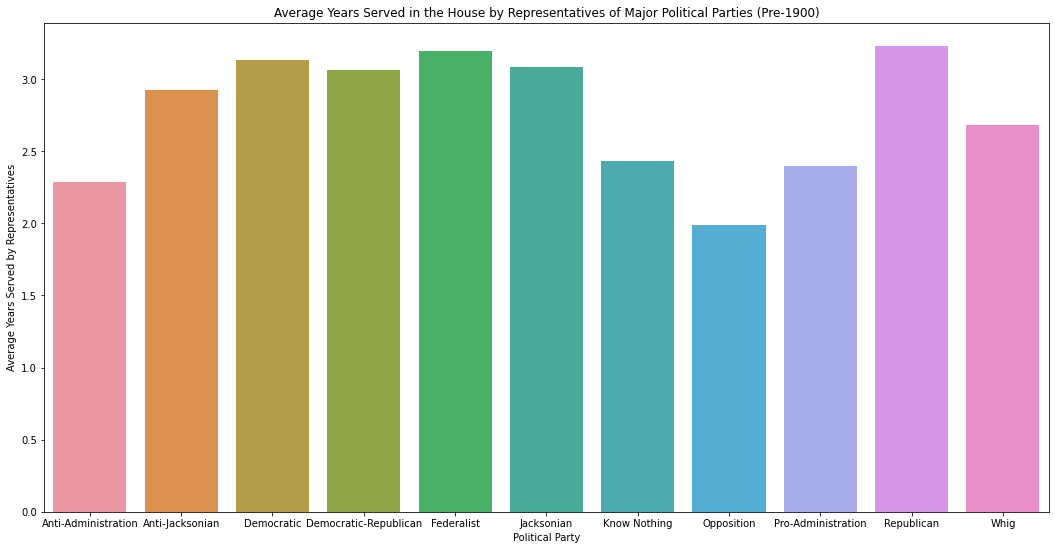

In [64]:
fig, ax1 = plt.subplots(figsize=(18,9))
graph = sns.barplot(ax = ax1, x='Party',y='mean',data=money)
graph.set(xlabel='Political Party', ylabel='Average Years Served by Representatives')
plt.title('Average Years Served in the House by Representatives of Major Political Parties (Pre-1900)')

In [45]:
money

,Party,mean,count
0,Anti-Administration,2.290100,88
1,Anti-Jacksonian,2.924855,306
2,Democratic,3.135523,2247
3,Democratic-Republican,3.066448,971
4,Federalist,3.198758,353
5,Jacksonian,3.085360,435
6,Know Nothing,2.430954,57
7,Opposition,1.987851,99
8,Pro-Administration,2.395848,97
9,Republican,3.231134,1550
